# iFFT to create signal with given Spectrum

In [1]:
import numpy as np
from numpy import logspace, linspace
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, ifft
from scipy.signal import blackman

plt.rcParams['figure.figsize'] = [8, 5.0]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.grid'] = True

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def nicegrid(ax=plt):
    ax.grid(True, which='major', color='#666666', linestyle=':')
    ax.grid(True, which='minor', color='#999999', linestyle=':', alpha=0.2)
    ax.minorticks_on()

## Set Parameters

In [2]:
N = 2**12
fs = 20000
T = N/fs
t = np.arange(N)*T/N
delta_freq = fs/N

In [3]:
# bounds of rect in Y(f)
f_low = 500
f_high = 4000
# find equivalent positions in Y(f) 
n_low = int(f_low/delta_freq)
n_high = int(f_high/delta_freq)
L1 = np.arange(n_low,n_high)

## Create Y(f) and y[n]

In [4]:
Y_bl = np.zeros((N,), dtype=complex)
# create random phase needed for correct ifft process
rng = np.random.default_rng()
phi = rng.uniform(0, 2*np.pi, (len(L1),))

# create Y(f)
if (0):
    mag_temp = np.sin(np.pi*np.arange(0,n_high-n_low)/(n_high-n_low))
else:
    mag_temp = np.ones([1,n_high-n_low])
    
Y_bl[L1] = mag_temp*np.exp(1j*phi)
# add complex conjugate at upper end to ensure that y[n] real
Y_bl[N-L1] = np.conj(Y_bl[L1])

# create y[n]
y_bl = ifft(Y_bl)

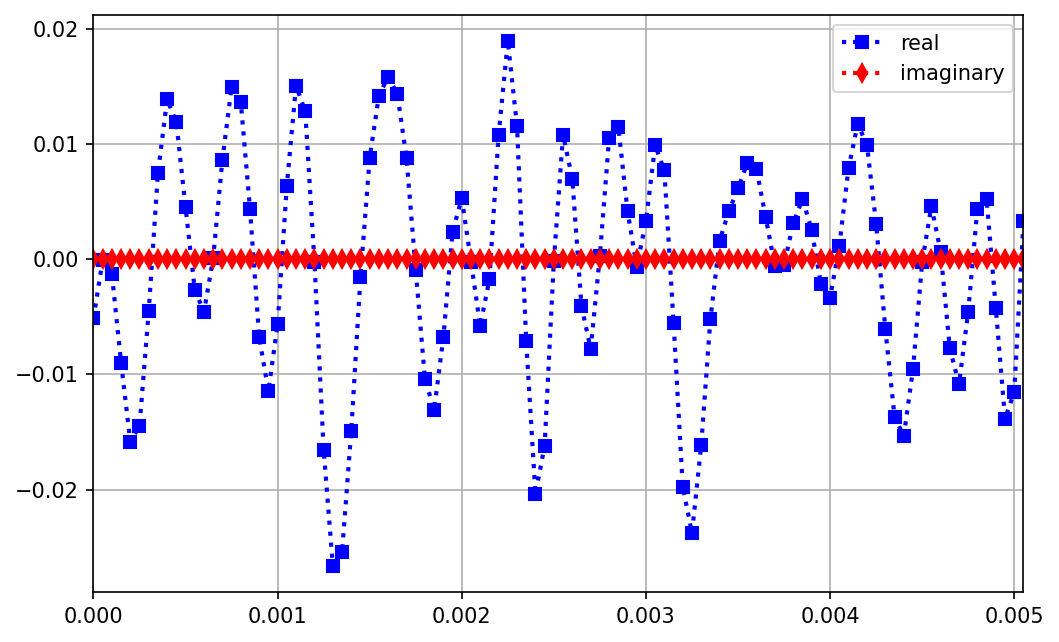

In [5]:
# check that it is real
plt.plot(t[0:n_low], y_bl.real[0:n_low], 'bs:', t[0:n_low], y_bl.imag[0:n_low], 'rd:')
plt.legend(('real', 'imaginary'))
plt.show()

## FFT the created data to confirm spectrum is right

In [6]:
Y_bl_fft = fft(y_bl)
f_bl = fftfreq(N, 1/fs)

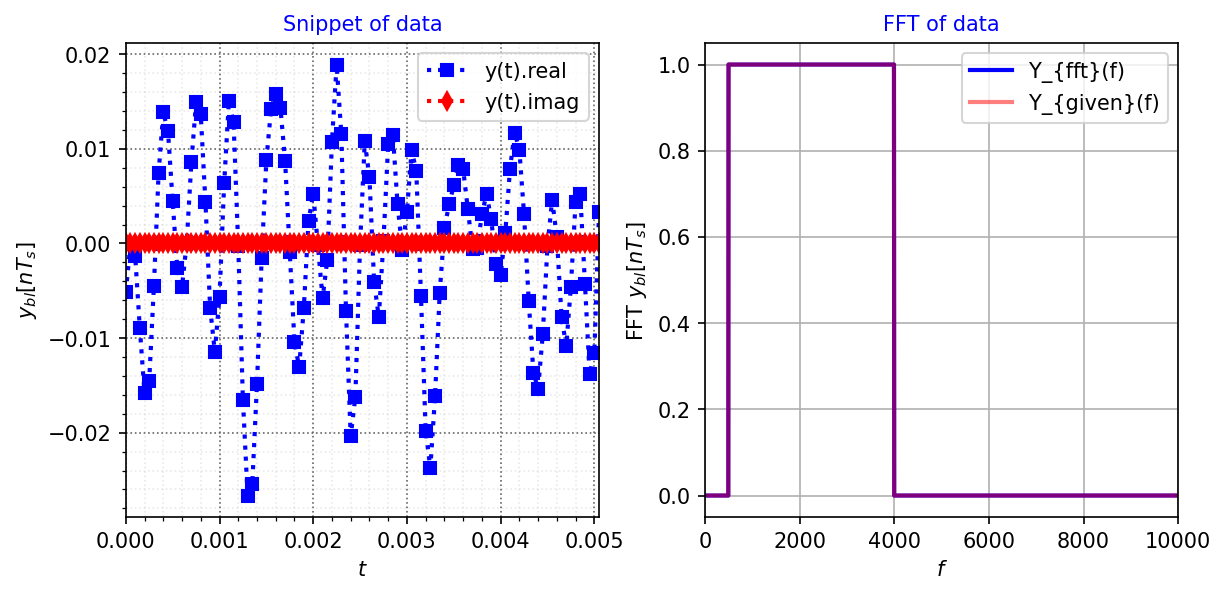

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
fig.tight_layout(pad=2)
ax1.plot(t[0:n_low], y_bl.real[0:n_low], 'bs:', t[0:n_low], y_bl.imag[0:n_low], 'rd:')
ax1.set_ylabel('$y_{bl}[nT_s]$')
ax1.set_xlabel('$t$')
ax1.legend(['y(t).real','y(t).imag'])
ax1.set_title('Snippet of data')
nicegrid(ax1)

ax2.plot(f_bl[0:N//2], np.abs(Y_bl_fft[0:N//2]),'b-')
ax2.plot(f_bl[0:N//2], np.abs(Y_bl[0:N//2]),'r-',alpha=0.5)
ax2.set_ylabel('FFT $y_{bl}[nT_s]$')
ax2.set_xlabel('$f$')
ax2.set_xlim([0, fs/2])
ax2.legend(['Y_{fft}(f)','Y_{given}(f)'])
ax2.set_title('FFT of data')
plt.show()

In [15]:
import csv
f = open('data/ifft_csv_file'+str(fs)+'.csv', 'w')
writer = csv.writer(f)
for i in range(len(y_bl)):
    writer.writerow([np.real(y_bl[i])])
f.close()

In [16]:
len(y_bl)

4096

## Filter data 

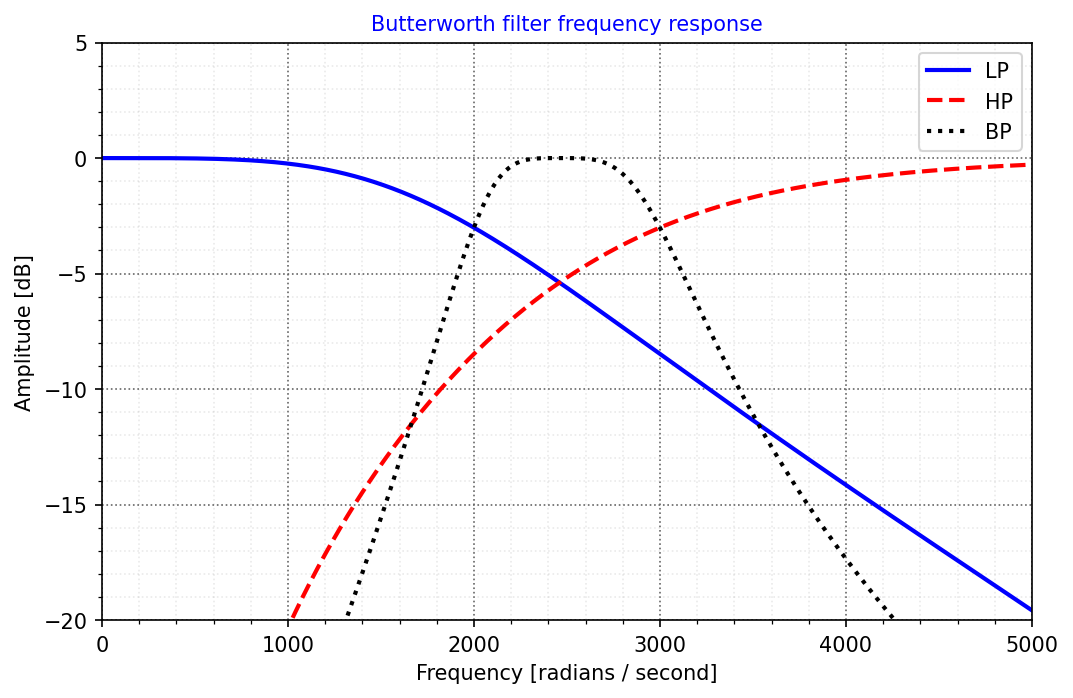

In [10]:
eps = 1e-12
b_low, a_low = signal.butter(2, 2000, 'low', fs=fs)
f_low, h_low = signal.freqz(b_low, a_low,fs=fs,worN=1000)

b_high, a_high = signal.butter(2, 3000, 'high', fs=fs)
f_high, h_high = signal.freqz(b_high, a_high,fs=fs,worN=1000)

b_bp, a_bp = signal.butter(2, [2000,3000], 'bandpass', fs=fs)
f_bp, h_bp = signal.freqz(b_bp, a_bp,fs=fs,worN=1000)

plt.plot(f_low, 20 * np.log10(abs(h_low+eps)),'b-',label='LP')
plt.plot(f_high, 20 * np.log10(abs(h_high+eps)),'r--',label='HP')
plt.plot(f_bp, 20 * np.log10(abs(h_bp+eps)),'k:',label='BP')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.xlim([0, fs/4])
plt.ylim([-20, 5])
nicegrid()
plt.legend()
plt.show()

In [11]:
yf_lp = signal.lfilter(b_low, a_low, y_bl)
yf_hp = signal.lfilter(b_high, a_high, y_bl)
yf_bp = signal.lfilter(b_bp, a_bp, y_bl)

Y_lp_fft = fft(yf_lp)
Y_hp_fft = fft(yf_hp)
Y_bp_fft = fft(yf_bp)

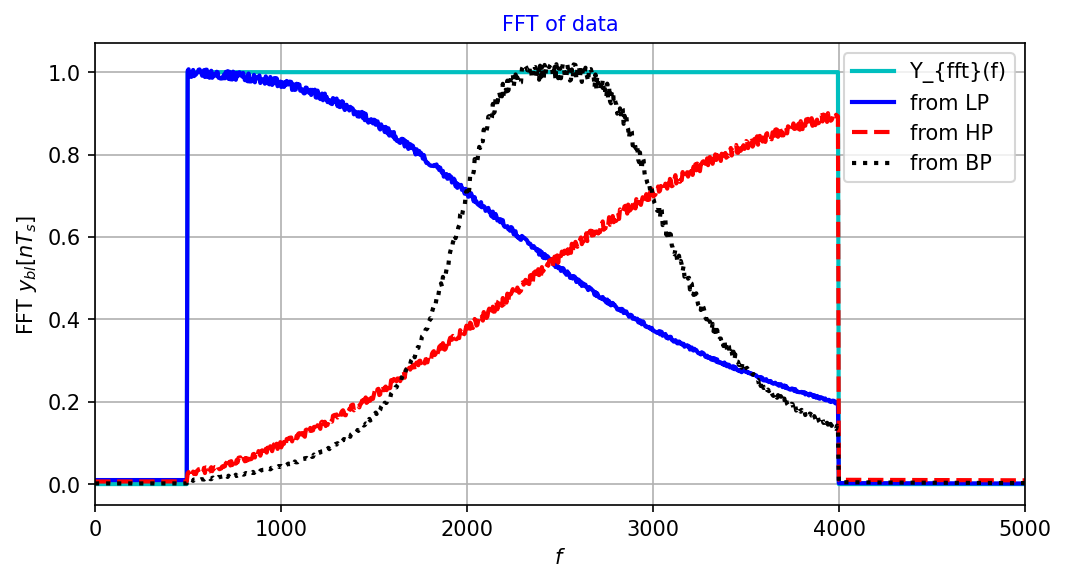

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4), dpi=150)
ax1.plot(f_bl[0:N//2], np.abs(Y_bl_fft[0:N//2]),'c-')
ax1.plot(f_bl[0:N//2], np.abs(Y_lp_fft[0:N//2]),'b-')
ax1.plot(f_bl[0:N//2], np.abs(Y_hp_fft[0:N//2]),'r--')
ax1.plot(f_bl[0:N//2], np.abs(Y_bp_fft[0:N//2]),'k:')
ax1.set_ylabel('FFT $y_{bl}[nT_s]$')
ax1.set_xlabel('$f$')
ax1.set_xlim([0, fs/4])
ax1.legend(['Y_{fft}(f)','from LP','from HP','from BP'])
ax1.set_title('FFT of data')
plt.show()